# Quantum Transfer learning

In this example, we show the method to train quantum neural network with transfer learning method. We utilize the classical pre-trained model -- ResNet18 and replace its last fully-connected layer with the self-defined quantum model. 

## About this example
In this example, the main struture of the example follow the one provided by [Pennylane](https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning.html). The core quantum operation of the framework is different from Pennylane. This example aimed at showing the performance and the usage of the new quantum processing framework -- JDQAI. 

# Initialization

In [1]:
#import sys 
#sys.path.append("..") 
import tedq as qai

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
torch.manual_seed(4)

# Numpy
import numpy as np
np.random.seed(4)

# Plot
import matplotlib.pyplot as plt

# Others
import time
import os
import copy

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"
TF_CPP_MIN_LOG_LEVEL=0

# Parameters

In [2]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
num_epochs = 10              # Number of training epochs (for simple test, choose num_epochs to 1)
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer
data_dir = "./_data/hymenoptera_data"

# Load images

In [3]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
    }


## Initialize image plotter

In [4]:
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

## Preview a set of data

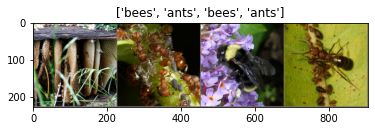

In [5]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# Define quantum model 

### template qunatum circuit

In [6]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qai.Hadamard(qubits=[idx])


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qai.RY(element, qubits=[idx])


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qai.CNOT(qubits=[i, i+1])
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qai.CNOT(qubits=[i, i+1])


### Define the circuit with JDQAI framework

In [7]:
def circuitDef(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """
    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qai.expval(qai.PauliZ(qubits=[position])) for position in range(n_qubits)]
    return tuple(exp_vals)

In [8]:
circuit = qai.Circuit(circuitDef, n_qubits, torch.zeros(n_qubits), torch.zeros(q_depth, n_qubits))

### Draw quantum circuit with circuit visualizer in JDQAI

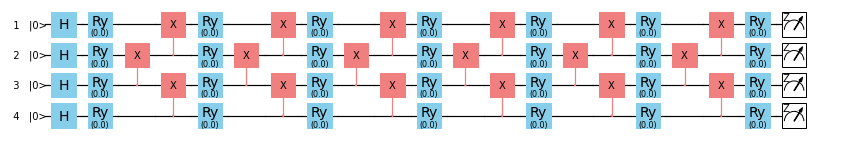

In [9]:
drawer = qai.matplotlib_drawer(circuit)
drawer.full_draw()

### Compile the circuit 

#### With pytorch backend and default back-propagation method

In [10]:
compiledCircuit = circuit.compilecircuit(backend="pytorch")

log10(flops) of this quantum circuit:   3.5504729571065754


#### With pytorch backend and parameter-shift method

In [11]:
#compiledCircuit = circuit.compilecircuit(backend="pytorch", diff_method = "param_shift")

### Implement quantum neural network with pytorch NN interface

In [12]:
cpu_device = torch.device("cpu")

In [13]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(2048, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)
        
        self.q_params = self.q_params.to(cpu_device) # You can use GPU for classical part and use CPU for quantum part
        def q_func(q_input_features):
            return compiledCircuit(q_input_features, self.q_params)
        
        from functorch import vmap
        self.batched_q_func = vmap(q_func)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit with CPU
        q_in = q_in.to(cpu_device) # You can use GPU for classical part and use CPU for quantum part
        q_out = self.batched_q_func(q_in).float()
        q_out = q_out.to(device) # Put the data back to GPU
        #print(q_out)

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

### Load pretrained model and exclude the parameters for training

In [14]:
model_hybrid = torchvision.models.resnet50(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False

/home/cyc/.local/share/virtualenvs/jd_project-64747iaN/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/cyc/.local/share/virtualenvs/jd_project-64747iaN/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Replace classical FC layer in the model with quantum neural network layer

In [15]:
# Notice that model_hybrid.fc (fully-connected layer) is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_hybrid = model_hybrid.to(device)

# Training

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, panel=None, linechart=None):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")
    
    if panel is not None:
        panel.show()
    if linechart is not None:
        x=0.
        y=0
        linechart.update(x,y)

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

                    
            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )
            
            if phase == "validation":
                if panel is not None:
                    panel.update(epoch_acc*100.)
                if linechart is not None:
                    x=time.time()-since
                    y=epoch_acc
                    linechart.update(x,y)

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()
                
    if linechart is not None:
        linechart.show()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model


### Define Cost function

In [17]:
criterion = nn.CrossEntropyLoss()

### Define optimizer

In [18]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [19]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

### initialize real-time monitor for QAI training

#### Monitor with accuracy v.s Time chart

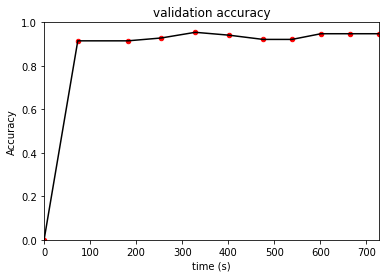

Training completed in 12m 7s
Best test loss: 0.2753 | Best test accuracy: 0.9542


In [20]:
chart = qai.Linechart()#accuracy vs time plot
model_hybrid = train_model(model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, 
                           num_epochs=num_epochs,linechart=chart)

#### Monitor with accuracy panel 

In [21]:
# panel = qai.Panel()#Accuracy panel plot
# model_hybrid = train_model(model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, 
#                            num_epochs=num_epochs,panel=panel)

## Result

### Trained quantum circuit

In [22]:
#drawer = qai.matplotlib_drawer(compiledCircuit)
#drawer.full_draw()

### Visualize the model

In [23]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

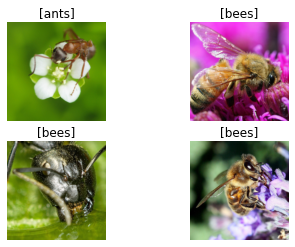

In [24]:
visualize_model(model_hybrid, num_images=batch_size)
plt.show()